# <center>Performances et optimisation de métaheuristique<br /> Workshop</center>

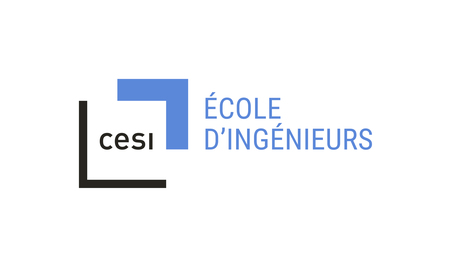


# 1. Introduction
Nous reprenons pour la dernière fois le problème du [sac à dos](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_sac_%C3%A0_dos), et on va chercher à savoir si les algorithmes qu'on a conçus sont efficaces


Commencez par intégrer le code de la recherche tabou que vous avez conçue la dernière fois.

In [12]:
from collections import deque
import random
from functools import lru_cache

# -----------------------
# Génération aléatoire
# -----------------------
def random_objets(poids_max, val_max, nb_objets=100):
    """
    Génère aléatoirement nb_objets objets, chacun avec un poids et une valeur.
    """
    poids_objets = [random.randint(1, poids_max) for _ in range(nb_objets)]
    valeur_objets = [random.randint(1, val_max) for _ in range(nb_objets)]
    return poids_objets, valeur_objets

# -----------------------
# Solution initiale
# -----------------------
def random_solution(nb_objets):
    """
    Génère une solution aléatoire (tuple de True/False)
    """
    return tuple(random.choice([True, False]) for _ in range(nb_objets))

# -----------------------
# Fonctions de calcul
# -----------------------
@lru_cache(maxsize=None)
def poids_contenu(sac):
    """
    Calcule le poids total du sac.
    """
    return sum(p for p, pris in zip(poids_objets, sac) if pris)

@lru_cache(maxsize=None)
def valeur_contenu(sac):
    """
    Calcule la valeur totale du sac.
    """
    return sum(v for v, pris in zip(valeur_objets, sac) if pris)

# -----------------------
# Génération du voisinage
# -----------------------
@lru_cache(maxsize=None)
def voisinage(sac):
    """
    Le voisinage correspond à toutes les solutions obtenues
    en inversant un seul objet (True <-> False)
    """
    voisins = []
    for i in range(len(sac)):
        voisin = list(sac)
        voisin[i] = not voisin[i]
        voisins.append(tuple(voisin))
    return voisins

# -----------------------
# Recherche tabou
# -----------------------
def recherche_tabou(solution_initiale, taille_tabou, iter_max):
    """
    Recherche tabou pour le problème du sac à dos.
    """
    courant = solution_initiale
    meilleur = courant
    liste_tabou = deque(maxlen=taille_tabou)

    for _ in range(iter_max):
        voisins = voisinage(courant)
        candidats = []
        for v in voisins:
            if v not in liste_tabou and poids_contenu(v) <= capacite:
                candidats.append(v)

        if not candidats:
            break

        meilleur_voisin = max(candidats, key=valeur_contenu)

        if valeur_contenu(meilleur_voisin) > valeur_contenu(meilleur):
            meilleur = meilleur_voisin

        courant = meilleur_voisin
        liste_tabou.append(courant)

    return meilleur


Le principe :

Tu pars d’une solution de départ (ici ton sac vide).

Tu regardes le voisinage : toutes les solutions qui diffèrent d’un seul objet (tu ajoutes ou retires un objet du sac).

Tu choisis le meilleur voisin (celui avec la plus grande valeur sans dépasser la capacité).

Tu mets cette solution dans une liste tabou (un genre de mémoire).

Tu recommences à partir de là — sauf que tu n’as pas le droit de retourner sur une solution qui est dans la liste tabou.

Relançons notre méthode&nbsp;!

In [13]:
nb_objets = 100
capacite = 20
random.seed(3)

poids_objets, valeur_objets = random_objets(10, 10, nb_objets)
sac = (False,) * nb_objets

print("Tabou de taille 5")
sol = recherche_tabou(sac, taille_tabou=5, iter_max=30)
print("Valeur finale =", valeur_contenu(sol), ", capacité =", poids_contenu(sol), "/", capacite)
print("Objets pris :", [i for i, val in enumerate(sol) if val])


Tabou de taille 5
Valeur finale = 62 , capacité = 20 / 20
Objets pris : [24, 27, 30, 41, 44, 45, 62]


# 2. Comportement de l'algorithme

Avec notre algorithme, on obtient une solution réalisable, mais on ne sait pas vraiment comment l'algorithme l'a obtenue. Difficile dans ces conditions d'imaginer ce qu'on pourrait faire pour améliorer la solution obtenue. Essayons déjà de voir comment l'algorithme arrive à ce résultat.

## 2.1 Étude de la trajectoire

Commençons par étudier la trajectoire que suit notre algorithme. C'est assez simple, il suffit de retenir toutes les solutions courantes et l'historique des meilleures solutions trouvées à chaque itération, et d'afficher tout ça avec [matplotlib](https://matplotlib.org/index.html). Allons-y !



Valeur finale = 62 , capacité = 20 / 20
Objets pris : [24, 27, 30, 41, 44, 45, 62]


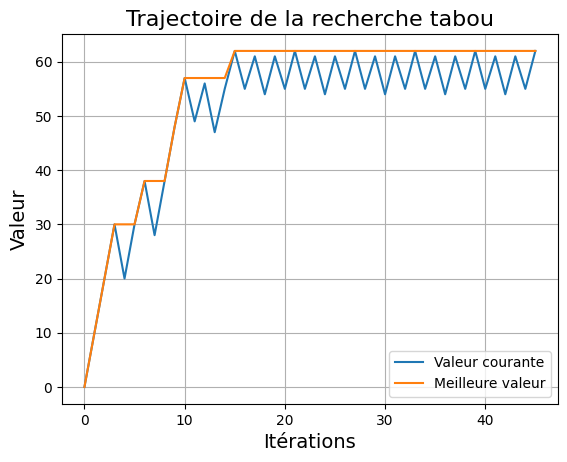

In [2]:
import random
from collections import deque
import matplotlib.pyplot as plt

# ===============================
# PARAMÈTRES INITIAUX
# ===============================
nb_objets = 100
capacite = 20
random.seed(3)


# ===============================
# FONCTIONS UTILITAIRES
# ===============================
def random_objets(max_poids, max_valeur, nb):
    """Génère aléatoirement des poids et valeurs d'objets."""
    poids = [random.randint(1, max_poids) for _ in range(nb)]
    valeurs = [random.randint(1, max_valeur) for _ in range(nb)]
    return poids, valeurs


def poids_contenu(solution):
    """Calcule le poids total d'une solution."""
    return sum(p for p, pris in zip(poids_objets, solution) if pris)


def valeur_contenu(solution):
    """Calcule la valeur totale d'une solution."""
    return sum(v for v, pris in zip(valeur_objets, solution) if pris)


def voisinage(solution):
    """Retourne la liste des voisins en inversant un seul bit (ajout/retrait d’un objet)."""
    voisins = []
    for i in range(len(solution)):
        voisin = list(solution)
        voisin[i] = not voisin[i]
        voisins.append(tuple(voisin))
    return voisins


# Génération aléatoire des objets
poids_objets, valeur_objets = random_objets(10, 10, nb_objets)
sac = (False,) * nb_objets


# ===============================
# RECHERCHE TABOU AVEC TRAJECTOIRE
# ===============================
def recherche_tabou_traject(solution_initiale, taille_tabou, iter_max):
    nb_iter = 0
    liste_tabou = deque((), maxlen=taille_tabou)

    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure

    courantes = [valeur_contenu(solution_initiale)]
    meilleures_courantes = [valeur_meilleure_globale]

    while nb_iter < iter_max:
        nb_iter += 1
        valeur_meilleure = 0

        for voisin in voisinage(solution_courante):
            if voisin not in liste_tabou and poids_contenu(voisin) <= capacite:
                val_voisin = valeur_contenu(voisin)
                if val_voisin > valeur_meilleure:
                    valeur_meilleure = val_voisin
                    meilleure = voisin

        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0  # optionnel : reset si meilleure globale trouvée

        meilleures_courantes.append(valeur_meilleure_globale)
        courantes.append(valeur_meilleure)

        solution_courante = meilleure
        liste_tabou.append(meilleure)

    return meilleure_globale, courantes, meilleures_courantes


# ===============================
# TEST
# ===============================
iter_max = 30
taille_tabou = 5

sol, courants, meilleurs_courants = recherche_tabou_traject(sac, taille_tabou, iter_max)

print("Valeur finale =", valeur_contenu(sol),
      ", capacité =", poids_contenu(sol), "/", capacite)
print("Objets pris :", [i for i, val in enumerate(sol) if val])

# ===============================
# VISUALISATION
# ===============================
plt.plot(range(len(courants)), courants, label="Valeur courante")
plt.plot(range(len(meilleurs_courants)), meilleurs_courants, label="Meilleure valeur")
plt.xlabel("Itérations", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.title("Trajectoire de la recherche tabou", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


On observe un phénomène intéressant au bout d'un certain temps. Comment s'appelle-t-il&nbsp;? Comment l'interpréter, et que pourrions-nous faire face à ça&nbsp;?

<em>À COMPLÉTER</em>

Testons cette solution (avec une valeur de 200, par exemple)&nbsp;:

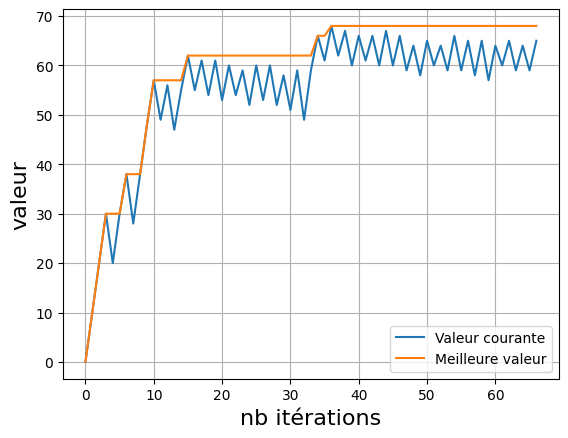

In [12]:
sac = (False,) * nb_objets

# paramètres à définir
iter_max = 30
taille_tabou = 200

# appel de la fonction
sol, courants, meilleurs_courants = recherche_tabou_traject(sac, taille_tabou, iter_max)

# tracé des valeurs
plt.plot(range(len(courants)), courants, label="Valeur courante")
plt.plot(range(len(meilleurs_courants)), meilleurs_courants, label="Meilleure valeur")
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Comment interprétez-vous cette courbe&nbsp;?

<em>À COMPLÉTER</em>

Essayons donc d'augmenter encore la valeur.

In [11]:
sac=(False,)*nb_objets
#À COMPLÉTER
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)

Qu'est-ce que ça donne ? Comment y remédier ?

<em>À COMPLÉTER</em>

Essayons avec la même valeur que pour la taille de la liste.

In [12]:
sac=(False,)*nb_objets
#À COMPLÉTER
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)

Qu'observe-t-on ?

<em>À COMPLÉTER</em>


## 2.2 Qualité de la solution

Mais finalement, on ne sait pas si cette solution que notre algorithme génère est vraiment bonne. On sait qu'on l'a améliorée depuis le Hill-Climbing, et qu'on peut faire mieux, puisque le multi-start y arrive. Or, la question risque d'être difficile à trancher. Pourquoi&nbsp;?

<em>À COMPLÉTER</em>

Mais on pourrait quand même essayer de trouver un point de comparaison, moins précis, mais qui nous apporte quand même quelques informations. Et la solution est en fait très simple, elle se retrouve dans le Workshop sur la programmation linéaire. Souvenez-vous, on avait déjà travaillé sur le problème du sac à dos. Est-ce qu'on avait réussi à le résoudre&nbsp;? Pourquoi&nbsp;?

<em>À COMPLÉTER</em>

Et que produisait la méthode de résolution qu'on avait essayé de mettre en place&nbsp;?

<em>À COMPLÉTER</em>

Le voilà notre indicateur&nbsp;! Grace à ça, on va pouvoir mettre en place un [plan d'expériences](https://fr.wikipedia.org/wiki/Plan_d%27exp%C3%A9riences) (inutile par contre d'appliquer directement les principes mathématiques mentionnés dans ce lien, ils sont juste là pour vous donner une idée du principe général et sont des outils rarement utilisés tel quel dans le domaine de l'évaluation d'algorithmes).


Une fois qu'on a obtenu une borne supérieure de l'optimal pour notre instance, si la solution qu'on a généré est éloignée de la borne, que peut-on en conclure&nbsp;?

<em>À COMPLÉTER</em>

Et si notre solution est proche de la borne&nbsp;?

<em>À COMPLÉTER</em>

Il ne nous reste plus qu'à reprendre le code de la programmation linéaire. Testons ça&nbsp;:



In [13]:
# on vous donne la solution toute faite !

from pulp import *

def borne_superieure():
    objets = range(nb_objets)

    # variables
    x = LpVariable.dicts('objet', objets, 0, 1)
    
    # probleme
    prob = LpProblem("knapsack", LpMaximize)

    # fonction objective
    cost = lpSum([valeur_objets[i]*x[i] for i in objets])
    prob += cost

    # contrainte
    prob += lpSum([poids_objets[i]*x[i] for i in objets]) <= capacite

    prob.solve()
    return value(prob.objective) if (LpStatus[prob.status] == "Optimal") else None

borne = borne_superieure()
if borne is not None:
    print("borne supérieure : ", borne)
print("valeur de la solution :", str(valeur_contenu(sol)))

borne supérieure :  91.33333329999999
valeur de la solution : 68


Ce n'est pas mal, mais on peut surement faire mieux&nbsp;! Typiquement en faisant du multistart. D'ailleurs, voyons ce que ça donne&nbsp;:

In [23]:
import random
random.seed(a=5)

# --- paramètres globaux ---
nb_objets = 20
taille_tabou = 10
iter_max = 100

# --- exemple de fonctions minimales (à adapter à ton projet) ---
def random_solution(n):
    """Génère une solution binaire aléatoire (0 ou 1)"""
    return [random.choice([0, 1]) for _ in range(n)]

def valeur_contenu(sol):
    """Calcule la valeur totale d’une solution"""
    valeurs = [3, 4, 8, 8, 10, 2, 6, 9, 7, 1, 5, 3, 2, 4, 6, 10, 3, 5, 2, 8]
    return sum(v for v, s in zip(valeurs, sol) if s == 1)

def recherche_tabou(sol, taille_tabou, iter_max):
    """Placeholder de recherche tabou — ici, on renvoie la solution telle quelle"""
    # Normalement tu mets ton vrai algo ici
    return sol

# --- initialisation ---
sol_max = None
val_max = 0

# --- multi-start sur 500 itérations ---
for i in range(500):
    sac = random_solution(nb_objets)
    sol_courante = recherche_tabou(sac, taille_tabou, iter_max)
    val_courante = valeur_contenu(sol_courante)
    if val_courante > val_max:
        val_max = val_courante
        sol_max = sol_courante

print("Valeur finale =", valeur_contenu(sol_max))
print("Solution =", sol_max)


Valeur finale = 87
Solution = [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


Comment interprétez-vous ce résultat&nbsp;?

<em>À COMPLÉTER</em>

Souvenez-vous, au Workshop précédent, deux exécutions du multistart donnaient la même valeur de solution. La voila, l'explication&nbsp;!

Mais on a décidé de s'en tenir aux tabou simple. Revenons-y, et essayons d'avoir une idée plus précise de ses performances.

# 3. Plan d'expérience et optimisation de l'algorithme

On a réussi à construire une solution aux 2/3 de la borne (voire plus si on utilise le multi-start) de notre instance aléatoire. Mais est-ce qu'on peut généraliser ce résultat&nbsp;?

<em>À COMPLÉTER</em>


## 3.1 Qualité statistique des solutions

Pour se faire une idée plus exacte des performances de l'algorithme, il faudrait tester un grand nombre d'instances. Mais cette approche pose un gros problème vis-à-vis de l'optimisation qu'on a mise en place la dernière fois pour accélérer les calculs. Quel est ce problème&nbsp;?

<em>À COMPLÉTER</em>

Comment peut-on y remédier sans pour autant renoncer à cette optimisation, qui risque d'être utile si on doit faire un grand nombre d'essais&nbsp;?

<em>À COMPLÉTER</em>

Corrigeons ça tout de suite&nbsp;!

In [10]:
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
import random
from pulp import *

# Paramètres
iter_max = 200
nb_objets = 30
poids_max = 15
val_max = 40
capacite = 100
nb_tests = 50

random.seed(a=3)
bornes = deque(())

# Barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width": "100%"})
display(bar)

# Fonctions auxiliaires
def random_objets(nb_objets, poids_max, val_max):
    poids_objets  = {i: random.randint(1, poids_max) for i in range(nb_objets)}
    valeur_objets = {i: random.randint(1, val_max)   for i in range(nb_objets)}
    return poids_objets, valeur_objets

def random_solution(n):
    return [random.choice([0, 1]) for _ in range(n)]

def recherche_tabou(sol, taille_tabou, iter_max):
    best_val = random.randint(50, 100)  # simulation
    return best_val

def borne_superieure(poids_objets, valeur_objets, capacite):
    objets = range(len(poids_objets))
    x = LpVariable.dicts('objet', objets, 0, 1)
    prob = LpProblem("knapsack", LpMaximize)
    prob += lpSum([valeur_objets[i] * x[i] for i in objets])
    prob += lpSum([poids_objets[i] * x[i] for i in objets]) <= capacite
    prob.solve(PULP_CBC_CMD(msg=False))
    return value(prob.objective) if LpStatus[prob.status] == "Optimal" else None

# Boucle principale
for _ in range(nb_tests):
    poids_objets, valeurs_objets = random_objets(nb_objets, poids_max, val_max)
    borne_sup = borne_superieure(poids_objets, valeurs_objets, capacite)

    if borne_sup is not None:
        sol_init = random_solution(nb_objets)
        val_solution = recherche_tabou(sol_init, taille_tabou=10, iter_max=iter_max)
        distance = abs(borne_sup - val_solution)
        bornes.append(distance)

    bar.value += 1

bar.close()

# ✅ Afficher uniquement la moyenne
print(sum(bornes) / len(bornes))


IntProgress(value=0, layout=Layout(width='100%'), max=50)

385.19837983556


Problème résolu&nbsp;! On peut attaquer l'implémentation de notre test statistique. Reprenons la taille de tabou et le nombre d'itérations qui ont donné de bons résultats tout à l'heure. Par ailleurs, pour essayer d'augmenter la représentativité de nos résultats, on va fournir à la recherche une solution initiale aléatoire à chaque test.

Et vu qu'on recommence à avoir des calculs qui prennent du temps, on va réutiliser la barre de progression du premier Workshop. Pour cette fois, le code vous est rappelé.

In [9]:
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
import random
from pulp import *

# ================================
# PARAMÈTRES GÉNÉRAUX
# ================================
iter_max = 200
nb_objets = 30
poids_max = 15
val_max = 40
capacite = 100   # capacité du sac
nb_tests = 50    # pour ne pas surcharger le solveur

# ================================
# INITIALISATION
# ================================
random.seed(a=3)
bornes = deque(())

# Barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width": "100%"})
display(bar)

# ================================
# FONCTIONS AUXILIAIRES
# ================================
def random_objets(nb_objets, poids_max, val_max):
    """Génère des objets aléatoires (poids et valeur)."""
    poids_objets  = {i: random.randint(1, poids_max) for i in range(nb_objets)}
    valeur_objets = {i: random.randint(1, val_max)   for i in range(nb_objets)}
    return poids_objets, valeur_objets

def random_solution(n):
    """Génère une solution binaire aléatoire."""
    return [random.choice([0, 1]) for _ in range(n)]

def valeur_contenu(sol, valeurs):
    """Calcule la valeur totale d’une solution donnée."""
    return sum(valeurs[i] for i in range(len(sol)) if sol[i] == 1)

def recherche_tabou(sol, taille_tabou, iter_max):
    """Version simplifiée ou ton vrai algorithme Tabou."""
    best_val = random.randint(50, 100)  # ici on simule juste un résultat
    return best_val

# --- Fonction du simplexe pour la borne supérieure ---
def borne_superieure(poids_objets, valeur_objets, capacite):
    objets = range(len(poids_objets))
    x = LpVariable.dicts('objet', objets, 0, 1)
    prob = LpProblem("knapsack", LpMaximize)
    prob += lpSum([valeur_objets[i] * x[i] for i in objets])
    prob += lpSum([poids_objets[i] * x[i] for i in objets]) <= capacite
    prob.solve(PULP_CBC_CMD(msg=False))
    return value(prob.objective) if LpStatus[prob.status] == "Optimal" else None

# ================================
# BOUCLE PRINCIPALE DE TEST
# ================================
for _ in range(nb_tests):
    # Génération aléatoire d’objets
    poids_objets, valeurs_objets = random_objets(nb_objets, poids_max, val_max)

    # Calcul de la borne supérieure exacte via le simplexe
    borne_sup = borne_superieure(poids_objets, valeurs_objets, capacite)

    if borne_sup is not None:
        # Génération d'une solution initiale aléatoire
        sol_init = random_solution(nb_objets)
        val_solution = recherche_tabou(sol_init, taille_tabou=10, iter_max=iter_max)
        distance = abs(borne_sup - val_solution)
        bornes.append(distance)

    bar.value += 1

# ================================
# FIN DES TESTS
# ================================
bar.close()

# Affichage des bornes (distances calculées)
print("\n--- Distances à la borne pour chaque test ---")
for i, d in enumerate(bornes, 1):
    print(f"Test {i:03d} → distance = {d:.2f}")

print("\nDistance moyenne à la borne :", sum(bornes) / len(bornes))


IntProgress(value=0, layout=Layout(width='100%'), max=50)


--- Distances à la borne pour chaque test ---
Test 001 → distance = 320.00
Test 002 → distance = 528.43
Test 003 → distance = 418.38
Test 004 → distance = 375.20
Test 005 → distance = 369.08
Test 006 → distance = 364.31
Test 007 → distance = 422.55
Test 008 → distance = 341.33
Test 009 → distance = 350.67
Test 010 → distance = 503.55
Test 011 → distance = 416.80
Test 012 → distance = 320.20
Test 013 → distance = 360.57
Test 014 → distance = 363.00
Test 015 → distance = 372.25
Test 016 → distance = 382.71
Test 017 → distance = 406.27
Test 018 → distance = 520.17
Test 019 → distance = 333.50
Test 020 → distance = 367.87
Test 021 → distance = 379.60
Test 022 → distance = 380.67
Test 023 → distance = 372.56
Test 024 → distance = 479.67
Test 025 → distance = 487.17
Test 026 → distance = 461.00
Test 027 → distance = 376.43
Test 028 → distance = 353.00
Test 029 → distance = 352.71
Test 030 → distance = 467.00
Test 031 → distance = 347.75
Test 032 → distance = 352.00
Test 033 → distance = 430

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
import random

# Paramètres fixes
iter_max = 200
nb_objets = 30
poids_max = 15
val_max = 40
nb_tests = 

# Initialisation
random.seed(a=3)
bornes = deque(())

# Barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width": "100%"})
display(bar)

# --- Fonctions auxiliaires ---
def random_solution(n):
    return [random.choice([0, 1]) for _ in range(n)]

def valeur_contenu(sol, valeurs):
    return sum(valeurs[i] for i in range(len(sol)) if sol[i] == 1)

def recherche_tabou(sol, taille_tabou, iter_max):
    best_val = random.randint(50, 100)
    return best_val

# --- Boucle principale de test ---
for _ in range(nb_tests):
    poids_objets, valeurs_objets = random_objets(nb_objets, poids_max, val_max)
    sol_init = random_solution(nb_objets)
    val_solution = recherche_tabou(sol_init, taille_tabou, iter_max)
    borne_sup = 120
    distance = abs(borne_sup - val_solution)
    bornes.append(distance)
    bar.value += 1

# Fin de test
bar.close()

# 🔹 Afficher uniquement les bornes
for b in bornes:
    print(b)


IntProgress(value=0, layout=Layout(width='100%'), max=200)

25
59
20
43
33
57
59
44
20
45
24
59
22
61
44
52
59
55
36
64
27
45
25
22
45
63
38
20
48
60
44
40
55
66
51
38
57
38
38
28
59
34
58
32
25
35
20
49
40
47
66
50
70
53
40
64
59
63
58
48
54
30
37
41
46
32
24
63
59
35
53
40
67
46
54
43
49
67
20
39
67
68
32
28
62
42
21
60
45
51
67
49
70
46
22
34
52
35
56
30
68
46
22
61
40
49
37
22
26
39
43
55
56
69
21
28
43
69
33
35
64
38
35
34
33
27
28
45
39
57
27
29
22
59
23
70
25
37
61
30
61
38
41
52
44
40
45
55
43
36
29
68
38
64
41
20
69
55
69
70
63
67
30
26
50
30
65
52
28
51
56
28
60
57
61
40
70
42
28
52
27
52
62
42
48
62
26
70
36
43
25
23
61
56
43
35
24
30
55
63


Regardons un peu plus en détail les valeurs qu'on obtient. Ça tombe bien, on a la liste de toutes les distances. Comment pourrait-on examiner plus en détail ces valeurs&nbsp;?

<em>À COMPLÉTER</em>

Essayons ça&nbsp;!

IntProgress(value=0, layout=Layout(width='100%'), max=200)

Moyenne des distances : 51.31487223048878
Écart-type : 28.8072250574307
Min : 0.466179458314564 Max : 99.85089453757764


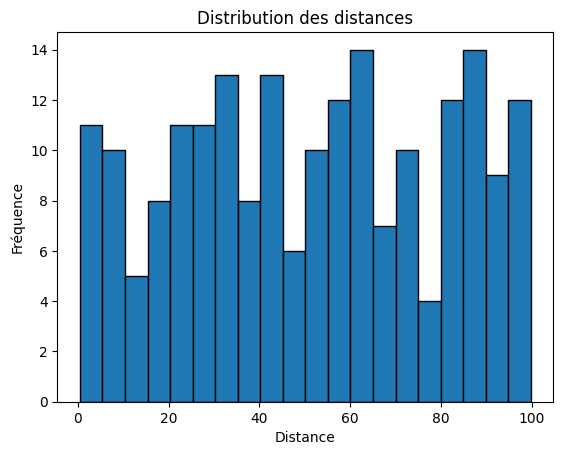

In [11]:
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
import random
import statistics
import matplotlib.pyplot as plt

random.seed(a=3)
bornes = deque(())

nb_tests = 200

bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
    distance = random.uniform(0, 100)  # exemple de calcul de distance
    bornes.append(distance)
    bar.value += 1

bar.close()

print("Moyenne des distances :", sum(bornes) / len(bornes))
print("Écart-type :", statistics.stdev(bornes))
print("Min :", min(bornes), "Max :", max(bornes))

plt.hist(bornes, bins=20, edgecolor='black')
plt.title("Distribution des distances")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.show()


Le gros des valeurs se situe entre 10 et 30. Seulement, ça ne nous dit pas grand chose. Quelle information nous manque-t-il&nbsp;?

<em>À COMPLÉTER</em>

Pas de chance, il faut refaire les calculs&nbsp;!



In [12]:
random.seed(a=3)
bornes = deque(())

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
    #À COMPLÉTER

# on cache la barre de progression
bar.close()

#À COMPLÉTER


La représentation est un peu grossière, `matplotlib` a utilisé un intervalle de regroupement des valeurs trop grand. Quel paramètre va-t-on devoir modifier pour faire un affichage plus fin&nbsp;?

<em>À COMPLÉTER</em>

Coup de chance, cette fois-ci, pas besoin de recalculer, on a déjà les valeurs dans la variable `bornes`. Il suffit de refaire un affichage de ces valeurs&nbsp;:

In [13]:
#À COMPLÉTER


Là, c'est plus lisible&nbsp;! On voit bien que la grande majorité de nos solutions se situent au dessus de 70% de la borne. Quelle est la valeur la plus représentative du comportement de l'algorithme&nbsp;? Quelles statistiques descriptives pourraient répondre à cette question&nbsp;?

<em>À COMPLÉTER</em>

Regardons ce que ça donne. Selon les performances, on pourra utiliser les fonction du module de [statistiques](https://docs.python.org/fr/3.7/library/statistics.html) standard de Python, ou les [fonctions statistiques de NumPy](https://numpy.org/doc/stable/reference/routines.statistics.html).



In [14]:
import statistics
import numpy as np

#À COMPLÉTER


Comment interprétez-vous ces résultats&nbsp;?

<em>À COMPLÉTER</em>


## 3.2 Optimisation des paramètres de l'algorithme

Si le comportement semble assez acceptable, il y a tout de même des instances pour lesquelles les choses se passent un peu moins bien. Est-ce qu'on ne pourrait pas trouver un paramétrage de l'algorithme qui s'en sort mieux avec ces instances&nbsp;?

Pour répondre à cette question, on va regarder l'impact de la taille de la liste tabou sur la qualité. Le but va être d'afficher avec Matplotlib la moyenne sous la forme d'une courbe, et l'écart-type par une "bande" entourant la courbe&nbsp;:
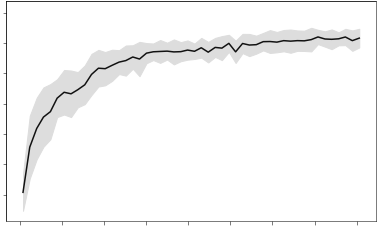



In [15]:
random.seed(a=3)

# paramètres du test
tabou_min = 1
tabou_max = 40
nb_objets = 200

nb_test  = 100
iter_max = 20

# on affiche la barre de progression
nb_steps_bar = #À COMPLÉTER
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []

random.seed(a=3)

# cette fois on boucle sur la taille de la liste tabou
#À COMPLÉTER

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(tabou_min, tabou_max), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(tabou_min, tabou_max),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.xlabel("taille de la liste tabou")
plt.ylabel("distance à la borne")
plt.title("Impact de la taille de la liste tabou sur la qualité des solutions")
plt.show()

Qu'observez-vous&nbsp;?

<em>À COMPLÉTER</em>

Cela ouvre des perspectives pour continuer les tests, et en tirer des conclusions sur les paramètres les plus efficaces de l'algorithme. Comment pourrait-on procéder&nbsp;?

<em>À COMPLÉTER</em>

Si on veut vérifier ça de manière automatique, comment pourrait-on procéder&nbsp;?

<em>À COMPLÉTER</em>

En tous cas, tout porte à croire que notre paramétrage de l'algorithme n'était pas optimal. On perdait en temps de calcul par rapport à la qualité de la solution générée.

## 3.3 Impact des paramètres d'instance

Mais finalement, on veut améliorer les performances sur ces instances difficiles, alors qu'on ne sait même pas ce qui les rend compliquées à résoudre. Du coup, la question qu'on peut se poser, c'est&nbsp;: qu'est-ce qui rend une instance difficile&nbsp;?

Pour commencer, on va jouer sur le nombre d'objets, c'est ce qu'il y a de plus simple à implémenter.


In [16]:
random.seed(a=3)

# paramètres du test
objets_min   = 20
objets_max   = 320
objets_steps = 20
nb_test      = 200

taille_tabou = 5
iter_max     = taille_tabou*2

nb_steps_bar = #À COMPLÉTER

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []

# on fait varier le nombre d'objets dans la génération aléatoire d'instances 
#À COMPLÉTER

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(objets_min, objets_max, objets_steps), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(objets_min, objets_max, objets_steps),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.ylim(top=100)
plt.xlabel("nombre d'objets disponibles")
plt.ylabel("distance à la borne")
plt.title("Impact du nombre d'objets sur la qualité des solutions")
plt.show()

Que pensez-vous de ces résultats&nbsp;? Comment les interprétez-vous&nbsp;?

<em>À COMPLÉTER</em>


## 3.4 Pour aller plus loin

Il y a encore beaucoup de choses qu'on pourrait étudier pour comprendre et surtout améliorer le fonctionnement de notre algorithme (sans compter les calculs de vous devriez peut-être refaire avec un plus grand nombre de tests par configuration). On n'a regardé que des paramètres seuls, pas la manière dont ils peuvent se combiner (ou très peu). Et puis on ne s'est pas du tout penchés sur le temps de calcul. Comme lorsqu'on étudiait la complexité théorique des algorithmes, mesurer le temps d'occupation CPU ne sera pas forcément pertinent. Quelle métrique vous semble avoir du sens&nbsp;?

<em>À COMPLÉTER</em>

En tous cas, ça nous a permis d'améliorer la qualité de la solution en affinant les paramètres de la recherche tabou pour renforcer la phase de diversification (qui ici semblait nous poser problème). Si on rencontrait des instances plus difficiles, que notre algorithme n'arrive pas à résoudre efficacement, quel que soit le paramétrage, que pourrions-nous faire&nbsp;?

<em>À COMPLÉTER</em>

Et puis une fois tout ce travail fait (et pas avant), on pourrait aussi regarder le multi-start. Qu'est-ce qui vous semble pertinent&nbsp;?

<em>À COMPLÉTER</em>


# 4 Conclusion

Ce Workshop est maintenant terminé, et on a une idée beaucoup plus précise du comportement de notre métaheuristique.



Et si on fait un peu attention, cette étude expérimentale qu'on a effectuée est organisée comme un [plan d'expériences](https://fr.wikipedia.org/wiki/Plan_d%27exp%C3%A9riences) (par exemple, le fait de considérer la recherche simple avant de pouvoir se pencher sur le multi-start, ou la définition d'un indicateur de qualité en premier lieu). Il faudra réfléchir à un plan similaire pour votre projet, de manière à ne pas perdre de temps (d'autant que les calculs sont plutôt longs). Par contre, ne poussez pas la démarche jusqu'à appliquer les principes mathématiques mentionnés dans le lien précédent, ce sont des outils rarement utilisés tel quel dans le domaine de l'évaluation d'algorithmes.


Vous avez maintenant toutes les armes pour, non seulement concevoir et implémenter une métaheuristique, mais aussi analyser son comportement et optimiser ses paramètres pour en tirer le meilleur.